In [90]:
import Project_library as pl
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import time
from progress.bar import Bar

In [122]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = [
    'CMU Serif Roman',  # primary CMU serif face
    'Times New Roman',  # fallback
    'Georgia',
    'serif'
]
plt.rcParams['axes.grid'] = True
# 3. Set the global font size:
plt.rcParams['font.size'] = 11  # change this number to taste

# 4. (Optional) Adjust axes titles and labels separately if you like:
plt.rcParams['axes.titlesize'] = 11 
plt.rcParams['axes.labelsize'] = 11

In [92]:
result_string = "../results_sweep1748721538"

results = []

with open(result_string, "rb") as f:
    config = pkl.load(f)
    while True:
        try:
            results.append(pkl.load(f))

        except:
            print("End of results reached ")
            break

config = config["Config"]

df = pd.DataFrame(results)


df.loc[0], df.keys()

End of results reached 


(reconfig_period                                                                      1
 time_step                                                                        0.001
 rmin                                                                                 0
 O                                                                                    2
 user_state_transition_probability    [[[[0.3 0.7], [0.3 0.7]], [[0.3 0.7], [0.3 0.7...
 label                                                                   Initial demand
 demand                               [25100000.0, 4700000.0, 4700000.0, 4800000.0, ...
 pred demand                          [25100000.0, 4700000.0, 4700000.0, 4800000.0, ...
 rates                                [205073150.0, 205730100.0, 206062400.0, 206062...
 schedule                             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
 achieved_capactiy                    [26454436.0, 4937522.5, 4945497.5, 5151560.0, ...
 min_capacity                   

In [93]:
A = df["user_state_transition_probability"].loc[0][0][0]
A

Array([[0.3, 0.7],
       [0.3, 0.7]], dtype=float32)

In [94]:
Number_of_beams = 19 

number_of_cells = df["rates"].loc[0].shape[0]

fraction_of_time_beam_is_activated = Number_of_beams/(number_of_cells*df["reconfig_period"].loc[0])

even_rates_per_cell = []

for rates in df["rates"].loc[0]:
    even_rates_per_cell.append(fraction_of_time_beam_is_activated*rates)

even_rates_per_cell = jnp.array(even_rates_per_cell)


number_of_realizations = 100

low_user_total= 80
high_user_total = 400


key = jrandom.PRNGKey(5)

nadir_cell , edge_cell = jnp.argmax(df["rates"].loc[0]), jnp.argmin(df["rates"].loc[0])

nadir_cell, edge_cell

O = config["O"]


rmins = config["rmin"]

iterations = config["iterations"]

number_of_cells = df.loc[0]["schedule"].T.shape[0]

CD_over_loops = []

CD_O_equal_two_edge =  [[], []]
CD_O_equal_two_nadir = [[], []]

CD_O_equal_five_edge = [[], []]
CD_O_equal_five_nadir= [[], []]

first_two_loops = True
first_five_loops = True 

cells_of_interst = [nadir_cell, edge_cell]

key = jrandom.PRNGKey(5)
key_small = jrandom.split(key, (80,))
key_large = jrandom.split(key, (400, ) )


varib_cases_coverd = 0

labels = ["Initial demand", "Initial demand", "Mode demand Variable", "Mode demand Sticky", "Expected demand Variable", "Expected demand Sticky"]

variability = ["Variability", "Inertial"]

# Loop through labels
for idx, label in enumerate(labels):
    if idx == 0 or idx == 2 or idx == 4:
        A = df["user_state_transition_probability"].loc[0][0][0]
        print("A Variable:", A)
    else:
        A = df["user_state_transition_probability"].loc[0][1][0]
        print("A Sticky:",A)
    # Loop over number of steps
    
    for o in O:
        time_window_small = jnp.zeros([low_user_total, o])
        time_window_large = jnp.zeros([high_user_total, o])
        # Loop over rmins
        for rmin in rmins:
            CD_nadir = []
            CD_edge = []
            # Loop over iterations 
            for iter in range(iterations):
                print("Processing label : ", label, " O : ", o, " rmin : ", rmin, " iter : ", iter)
                im_df = df[(df["label"] == label) & (df["O"] == o) & (df["rmin"] == rmin) & (df["iteration"] == iter)]

                capacity_list_for_all_cells = im_df["achieved_capactiy"].to_numpy()[0]

                total_users_in_cell_list = im_df["total number_of_users_in_cell"].to_list()


                active_users = im_df["demand"].to_numpy()[0]/100000

                for idk, cell_numbering in enumerate(cells_of_interst):
                    if idk == 0:
                        # Loop over iterations
                        for n in range(number_of_realizations):

                            if total_users_in_cell_list[0][cell_numbering] == low_user_total:

                                states = jnp.concatenate([jnp.ones(int(active_users[cell_numbering]), dtype=jnp.int32), 
                                                            jnp.zeros(total_users_in_cell_list[0][cell_numbering]-int(active_users[cell_numbering]), dtype=jnp.int32)])

                                # Window
                                window = pl.users_state_change(A, 
                                                                states, 
                                                                time_window_small, 
                                                                key_small)


                                demand_average_over_time = jnp.mean(jnp.sum(window, axis= 0))*100000

                                CD_nadir.append(capacity_list_for_all_cells[cell_numbering]/demand_average_over_time)

                                if o == 2 and first_two_loops:
                                    CD_O_equal_two_nadir[idx%2].append(even_rates_per_cell[cell_numbering]/demand_average_over_time)
                                elif o == 5 and first_five_loops:
                                    CD_O_equal_five_nadir[idx%2].append(even_rates_per_cell[cell_numbering]/demand_average_over_time)

                                key_small = jrandom.split(key_small[0], (low_user_total,))
                            else:

                                states = jnp.concatenate([jnp.ones(int(active_users[cell_numbering]), dtype=jnp.int32), 
                                                            jnp.zeros(total_users_in_cell_list[0][cell_numbering]-int(active_users[cell_numbering]), dtype=jnp.int32)])

                                # Window
                                window = pl.users_state_change(A, 
                                                                states, 
                                                                time_window_large, 
                                                                key_large)


                                demand_average_over_time = jnp.mean(jnp.sum(window, axis= 0))*100000

                                CD_nadir.append(capacity_list_for_all_cells[cell_numbering]/demand_average_over_time)

                                if o == 2 and first_two_loops:
                                    CD_O_equal_two_nadir[idx%2].append(even_rates_per_cell[cell_numbering]/demand_average_over_time)
                                elif o == 5 and first_five_loops:
                                    CD_O_equal_five_nadir[idx%2].append(even_rates_per_cell[cell_numbering]/demand_average_over_time)

                                key_large = jrandom.split(key_large[0], (high_user_total,))
                    else:
                        # Loop over iterations
                        for n in range(number_of_realizations):

                            if total_users_in_cell_list[0][cell_numbering] == low_user_total:

                                states = jnp.concatenate([jnp.ones(int(active_users[cell_numbering]), dtype=jnp.int32), 
                                                            jnp.zeros(total_users_in_cell_list[0][cell_numbering]-int(active_users[cell_numbering]), dtype=jnp.int32)])

                                # Window
                                window = pl.users_state_change(A, 
                                                                states, 
                                                                time_window_small, 
                                                                key_small)


                                demand_average_over_time = jnp.mean(jnp.sum(window, axis= 0))*100000

                                CD_edge.append(capacity_list_for_all_cells[cell_numbering]/demand_average_over_time)
                                
                                if o == 2 and first_two_loops:
                                    CD_O_equal_two_edge[idx%2].append(even_rates_per_cell[cell_numbering]/demand_average_over_time)
                                elif o == 5 and first_five_loops:
                                    CD_O_equal_five_edge[idx%2].append(even_rates_per_cell[cell_numbering]/demand_average_over_time)

                                key_small = jrandom.split(key_small[0], (low_user_total,))
                            else:

                                states = jnp.concatenate([jnp.ones(int(active_users[cell_numbering]), dtype=jnp.int32), 
                                                            jnp.zeros(total_users_in_cell_list[0][cell_numbering]-int(active_users[cell_numbering]), dtype=jnp.int32)])

                                # Window
                                window = pl.users_state_change(A, 
                                                                states, 
                                                                time_window_large, 
                                                                key_large)


                                demand_average_over_time = jnp.mean(jnp.sum(window, axis= 0))*100000

                                CD_edge.append(capacity_list_for_all_cells[cell_numbering]/demand_average_over_time)

                                if o == 2 and first_two_loops:
                                    CD_O_equal_two_edge[idx%2].append(even_rates_per_cell[cell_numbering]/demand_average_over_time)
                                elif o == 5 and first_five_loops:
                                    CD_O_equal_five_edge[idx%2].append(even_rates_per_cell[cell_numbering]/demand_average_over_time)

                                key_large = jrandom.split(key_large[0], (high_user_total,))
    
            print("Append CD_over_loops")
            CD_over_loops.append({"CD_nadir" : CD_nadir,
                                  "CD_edge"   :CD_edge,
                                  "CD"
                                  "Label"    : label,
                                  "Variability": variability[idx%2],
                                  "rmin"     : rmin,
                                  "O"        : o})
        
    if o == 2 and varib_cases_coverd == 1:
        first_two_loops = False
        print("The statement is false for o = 2")

    if o == 5 and varib_cases_coverd == 1:
        first_five_loops = False
        print("The statement is false for o  =  5")
    
    varib_cases_coverd +=1

A Variable: [[0.3 0.7]
 [0.3 0.7]]
Processing label :  Initial demand  O :  2  rmin :  0  iter :  0
Processing label :  Initial demand  O :  2  rmin :  0  iter :  1
Processing label :  Initial demand  O :  2  rmin :  0  iter :  2
Processing label :  Initial demand  O :  2  rmin :  0  iter :  3
Processing label :  Initial demand  O :  2  rmin :  0  iter :  4
Processing label :  Initial demand  O :  2  rmin :  0  iter :  5
Processing label :  Initial demand  O :  2  rmin :  0  iter :  6
Processing label :  Initial demand  O :  2  rmin :  0  iter :  7
Processing label :  Initial demand  O :  2  rmin :  0  iter :  8
Processing label :  Initial demand  O :  2  rmin :  0  iter :  9
Processing label :  Initial demand  O :  2  rmin :  0  iter :  10
Processing label :  Initial demand  O :  2  rmin :  0  iter :  11
Processing label :  Initial demand  O :  2  rmin :  0  iter :  12
Processing label :  Initial demand  O :  2  rmin :  0  iter :  13
Processing label :  Initial demand  O :  2  rmin : 

In [123]:
CD_over_loops = pd.DataFrame(CD_over_loops)

CD_over_loops.keys()

Index(['CD_nadir', 'CD_edge', 'CDLabel', 'Variability', 'rmin', 'O'], dtype='object')

In [124]:
five_line_styles = ["-", "--", "-.", ":", ":", ":", ":", ":", ":", ":"]
CD_O_equal_five_edge 

[[Array(1.6201258, dtype=float32),
  Array(1.614103, dtype=float32),
  Array(1.539694, dtype=float32),
  Array(1.6261936, dtype=float32),
  Array(1.614103, dtype=float32),
  Array(1.6764235, dtype=float32),
  Array(1.6384668, dtype=float32),
  Array(1.6081249, dtype=float32),
  Array(1.6572279, dtype=float32),
  Array(1.6323072, dtype=float32),
  Array(1.6384668, dtype=float32),
  Array(1.6446731, dtype=float32),
  Array(1.5506918, dtype=float32),
  Array(1.6699758, dtype=float32),
  Array(1.6021907, dtype=float32),
  Array(1.5846485, dtype=float32),
  Array(1.5562499, dtype=float32),
  Array(1.6446731, dtype=float32),
  Array(1.6201258, dtype=float32),
  Array(1.5731655, dtype=float32),
  Array(1.6572279, dtype=float32),
  Array(1.709424, dtype=float32),
  Array(1.6960691, dtype=float32),
  Array(1.528851, dtype=float32),
  Array(1.6446731, dtype=float32),
  Array(1.709424, dtype=float32),
  Array(1.6764235, dtype=float32),
  Array(1.6764235, dtype=float32),
  Array(1.614103, dtype=fl

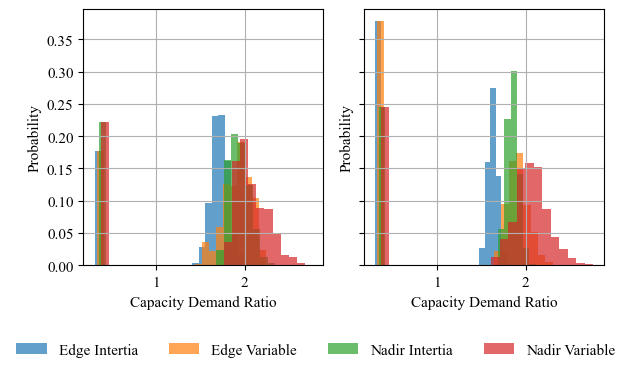

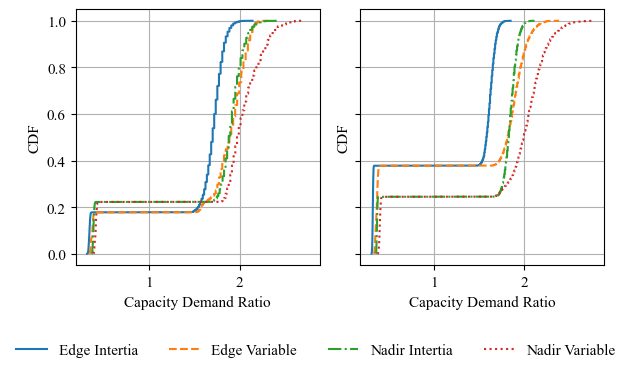

In [197]:
fig1, axs1 = plt.subplots(1,2, figsize = (6.1, 3.5),
                          sharex=True,
                          sharey=True)
axs1 = axs1.flatten()

# Plot the naive value distribution.
CD_O_equal_two_edge 
CD_O_equal_two_nadir 

CD_O_equal_five_edge 
CD_O_equal_five_nadir

Labels_for_naive_case = ["Edge Intertia","Edge Variable","Nadir Intertia", "Nadir Variable"]

for idx, ax in enumerate(axs1):
    ax.set_xlabel("Capacity Demand Ratio")
    ax.set_ylabel("Probability")
    if idx == 0:
        for idk ,CD in enumerate(CD_O_equal_two_edge):
            CD = np.array(CD)
            weights_percent = np.ones(len(CD)) / len(CD)
            ax.hist(CD, bins=25,weights=weights_percent, alpha = 0.7, label=Labels_for_naive_case[idk])

        for idk, CD in enumerate(CD_O_equal_two_nadir):
            CD = np.array(CD)
            weights_percent = np.ones(len(CD)) / len(CD)
            ax.hist(CD,weights=weights_percent, bins=25, alpha = 0.7, label=Labels_for_naive_case[2+idk])

    if idx == 1:
        for CD in CD_O_equal_five_edge:
            CD = np.array(CD)
            weights_percent = np.ones(len(CD)) / len(CD)
            ax.hist(CD,weights=weights_percent, bins=25, alpha = 0.7)

        for CD in CD_O_equal_five_nadir:
            CD = np.array(CD)
            weights_percent = np.ones(len(CD)) / len(CD)
            ax.hist(CD,weights=weights_percent, bins=25, alpha = 0.7)


fig2, axs2 = plt.subplots(1,2,figsize=(6.1, 3.5),
                          sharex=True,
                          sharey=True)
for idx, ax in enumerate(axs2):
    ax.set_xlabel("Capacity Demand Ratio")
    ax.set_ylabel("CDF")
    if idx == 0:
        for idk, CD in enumerate(CD_O_equal_two_edge):
            CD = np.array(CD)

            sorted_CD = np.sort(CD)
            n = len(sorted_CD)
            cdf = np.arange(1, n + 1) / n
            
            ax.plot( sorted_CD, cdf, linestyle = five_line_styles[idk], label=Labels_for_naive_case[idk])
            

        for idk, CD in enumerate(CD_O_equal_two_nadir):
            CD = np.array(CD)

            sorted_CD = np.sort(CD)
            n = len(sorted_CD)
            cdf = np.arange(1, n + 1) / n
            
            ax.plot(sorted_CD, cdf, linestyle = five_line_styles[2+idk], label=Labels_for_naive_case[2+idk])
    if idx == 1:

        for idk, CD in enumerate(CD_O_equal_five_edge):
            CD = np.array(CD)

            sorted_CD = np.sort(CD)
            n = len(sorted_CD)
            cdf = np.arange(1, n + 1) / n
            
            ax.plot( sorted_CD, cdf, linestyle = five_line_styles[idk])

        for idk ,CD in enumerate(CD_O_equal_five_nadir):
            CD = np.array(CD)

            sorted_CD = np.sort(CD)
            n = len(sorted_CD)
            cdf = np.arange(1, n + 1) / n
            
            ax.plot(sorted_CD, cdf, linestyle = five_line_styles[2+idk])
# Centered legend below each subplot
fig2.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.08),  
    ncol=4,                      
    frameon=False
)
fig1.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.08),  
    ncol=4,                      
    frameon=False
)

fig2.tight_layout(rect=[0, 0.05, 1, 1])
fig1.tight_layout(rect=[0, 0.05, 1, 1])
fig1.savefig("CDR_histogram_naive.pdf", bbox_inches='tight')
fig2.savefig("CDR_CDF_naive.pdf", bbox_inches='tight')

In [126]:
CD_over_loops[(CD_over_loops["rmin"] == 0) & (CD_over_loops["O"] == 2)]

,CD_nadir,CD_edge,CDLabel,Variability,rmin,O
0,"[0.9523508, 0.95053333, 0.9824053, 0.9615434, ...","[1.0237832, 0.9858653, 0.9506558, 1.0438573, 1...",Initial demand,Variability,0,2
6,"[1.0333599, 1.0620031, 1.0355083, 1.0574936, 1...","[1.0976645, 1.0754894, 1.0864638, 1.0754894, 1...",Initial demand,Inertial,0,2
12,"[0.9704909, 0.9540728, 1.0011178, 0.9952289, 0...","[0.9479473, 0.9658331, 0.90600276, 0.9939642, ...",Mode demand Variable,Variability,0,2
18,"[1.0519311, 1.0453702, 1.0367486, 1.0563511, 1...","[1.0541925, 1.0976645, 1.0864638, 1.0864638, 1...",Mode demand Sticky,Inertial,0,2
24,"[0.97421634, 0.98556644, 1.0070769, 0.99328125...","[0.9844068, 0.9750315, 1.0341244, 1.0554465, 0...",Expected demand Variable,Variability,0,2
30,"[1.0519311, 1.047548, 1.0453702, 1.047548, 1.0...","[1.1090984, 1.0647345, 1.0541925, 1.0976645, 1...",Expected demand Sticky,Inertial,0,2


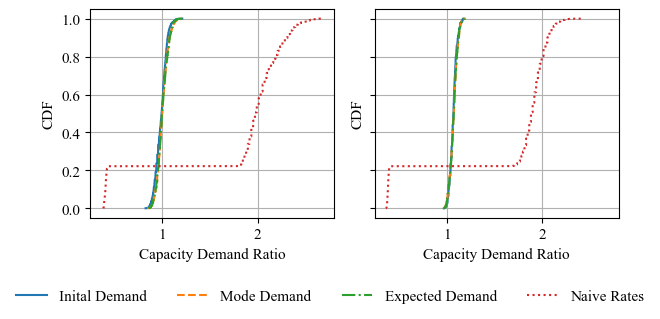

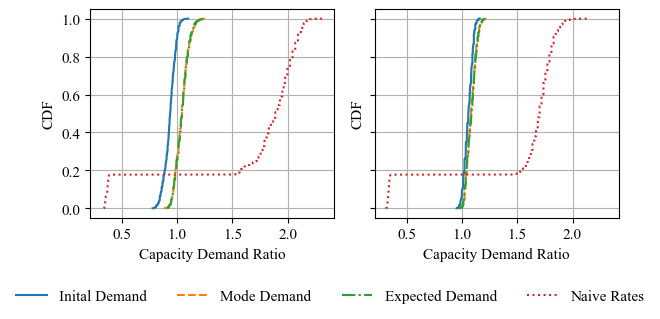

In [189]:
rmin = 200000
df_rmin_zero_o_two_inertial = CD_over_loops[(CD_over_loops["rmin"] == rmin) & (CD_over_loops["O"] == 2) & (CD_over_loops["Variability"] == "Inertial")]
df_rmin_zero_o_two_variable= CD_over_loops[(CD_over_loops["rmin"] == rmin) & (CD_over_loops["O"] == 2) & (CD_over_loops["Variability"] == "Variability")]

df_rmin_zero_o_five_inertial = CD_over_loops[(CD_over_loops["rmin"] == rmin) & (CD_over_loops["O"] == 5) & (CD_over_loops["Variability"] == "Inertial")]
df_rmin_zero_o_five_variable = CD_over_loops[(CD_over_loops["rmin"] == rmin) & (CD_over_loops["O"] == 5) & (CD_over_loops["Variability"] == "Variability")]

fig, axs = plt.subplots(1,2, figsize = (6.1, 3)
                          , sharex=True,
                          sharey=True)

labels_for_optimisatoin_plots = ["Inital Demand", "Mode Demand", "Expected Demand", "Naive Rates"]

# Plot the variable case and intertial case in the two axes. Use o = 2 and rmin = 0
for idx, ax in enumerate(axs):
    ax.set_xlabel("Capacity Demand Ratio")
    ax.set_ylabel("CDF")

    if idx == 0: # Variable case nadir
        for idk in range(4):
            if idk < 3:
                CD = df_rmin_zero_o_two_variable["CD_nadir"].iloc[idk]
            else:
                CD = CD_O_equal_two_nadir[1]
            CD = np.array(CD)

            sorted_CD = np.sort(CD)
            n = len(sorted_CD)
            cdf = np.arange(1, n + 1) / n
            
            ax.plot( sorted_CD, cdf, linestyle = five_line_styles[idk], label=labels_for_optimisatoin_plots[idk])
            
            
    if idx == 1: # Inertial case

        for idk in range(4):
            if idk < 3:
                CD = df_rmin_zero_o_two_inertial["CD_nadir"].iloc[idk]
            else:
                CD = CD_O_equal_two_nadir[0]
            CD = np.array(CD)

            sorted_CD = np.sort(CD)
            n = len(sorted_CD)
            cdf = np.arange(1, n + 1) / n
            
            ax.plot( sorted_CD, cdf, linestyle = five_line_styles[idk])

fig.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.08),  
    ncol=4,                      
    frameon=False
)

fig.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f"CDR_CDF_nadir_o2{rmin}.pdf", bbox_inches='tight')

fig, axs = plt.subplots(1,2, figsize = (6.1, 3)
                            , sharex=True,
                            sharey=True)

# Do the same but for the edge case
for idx, ax in enumerate(axs):
    ax.set_xlabel("Capacity Demand Ratio")
    ax.set_ylabel("CDF")

    if idx == 0: # Variable case nadir
        for idk in range(4):
            if idk < 3:
                CD = df_rmin_zero_o_two_variable["CD_edge"].iloc[idk]
            else:
                CD = CD_O_equal_two_edge[1]
            CD = np.array(CD)

            sorted_CD = np.sort(CD)
            n = len(sorted_CD)
            cdf = np.arange(1, n + 1) / n
            
            ax.plot( sorted_CD, cdf, linestyle = five_line_styles[idk], label=labels_for_optimisatoin_plots[idk])
            
            
    if idx == 1: # Inertial case

        for idk in range(4):
            if idk < 3:
                CD = df_rmin_zero_o_two_inertial["CD_edge"].iloc[idk]
            else:
                CD = CD_O_equal_two_edge[0]
            CD = np.array(CD)

            sorted_CD = np.sort(CD)
            n = len(sorted_CD)
            cdf = np.arange(1, n + 1) / n
            
            ax.plot( sorted_CD, cdf, linestyle = five_line_styles[idk])

fig.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.08),  
    ncol=4,                      
    frameon=False
)
fig.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f"CDR_CDF_edge_o2{rmin}.pdf", bbox_inches='tight')

CDF at CD = 1: 0.5333333333333333 for idk: 0 Variable
CDF at CD = 1: 0.49666666666666665 for idk: 1 Variable
CDF at CD = 1: 0.49866666666666665 for idk: 2 Variable
CDF at CD = 1: 0.026 for idk: 0 Inertial
CDF at CD = 1: 0.042 for idk: 1 Inertial
CDF at CD = 1: 0.038 for idk: 2 Inertial
CDF at CD = 1: 0.8926666666666667 for idk: 0 Variable
CDF at CD = 1: 0.25733333333333336 for idk: 1 Variable
CDF at CD = 1: 0.254 for idk: 2 Variable
CDF at CD = 1: 0.08866666666666667 for idk: 0 Interial
CDF at CD = 1: 0.0033333333333333335 for idk: 1 Interial
CDF at CD = 1: 0.005333333333333333 for idk: 2 Interial


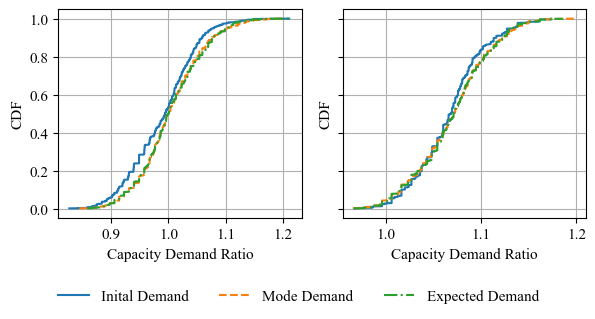

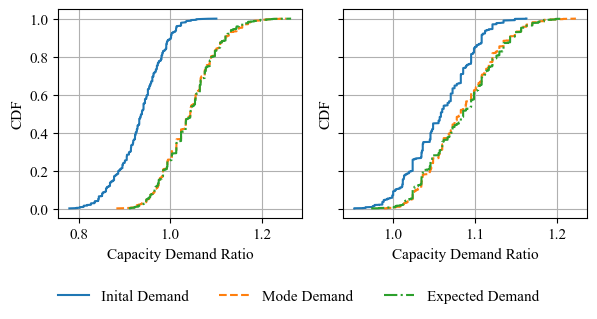

In [190]:
# Plot the same without the naive case
fig, axs = plt.subplots(1,2, figsize = (6.1, 3)
                            , sharex=False,
                            sharey=True)

# Do the same but for the edge case
for idx, ax in enumerate(axs):
    ax.set_xlabel("Capacity Demand Ratio")
    ax.set_ylabel("CDF")

    if idx == 0: # Variable case nadir
        for idk in range(3):
            CD = df_rmin_zero_o_two_variable["CD_nadir"].iloc[idk]
            CD = np.array(CD)

            sorted_CD = np.sort(CD)
            n = len(sorted_CD)
            cdf = np.arange(1, n + 1) / n

            # Calculate the CDF value at CD = 1
            cdf_at_1 = np.sum(sorted_CD <= 1) / n
            print("CDF at CD = 1:", cdf_at_1, "for idk:", idk, "Variable")
            
            ax.plot( sorted_CD, cdf, linestyle = five_line_styles[idk], label=labels_for_optimisatoin_plots[idk])
            
            
    if idx == 1: # Inertial case

        for idk in range(3):
            CD = df_rmin_zero_o_two_inertial["CD_nadir"].iloc[idk]
            CD = np.array(CD)

            sorted_CD = np.sort(CD)
            n = len(sorted_CD)
            cdf = np.arange(1, n + 1) / n
            
            # Calculate the CDF value at CD = 1
            cdf_at_1 = np.sum(sorted_CD <= 1) / n
            print("CDF at CD = 1:", cdf_at_1, "for idk:", idk, "Inertial")

            ax.plot( sorted_CD, cdf, linestyle = five_line_styles[idk])

fig.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.08),  
    ncol=3,                      
    frameon=False
)

fig.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f"CDR_cdf_nadir_no_naive_o2{rmin}.pdf", bbox_inches='tight')
fig, axs = plt.subplots(1,2, figsize = (6.1, 3)
                            , sharex=False,
                            sharey=True)

# Do the same but for the nadir case
for idx, ax in enumerate(axs):
    ax.set_xlabel("Capacity Demand Ratio")
    ax.set_ylabel("CDF")

    if idx == 0: # Variable case nadir
        for idk in range(3):
            CD = df_rmin_zero_o_two_variable["CD_edge"].iloc[idk]
            CD = np.array(CD)

            sorted_CD = np.sort(CD)
            n = len(sorted_CD)
            cdf = np.arange(1, n + 1) / n

            # Calculate the CDF value at CD = 1
            cdf_at_1 = np.sum(sorted_CD <= 1) / n
            print("CDF at CD = 1:", cdf_at_1, "for idk:", idk, "Variable")

            ax.plot( sorted_CD, cdf, label=labels_for_optimisatoin_plots[idk], linestyle = five_line_styles[idk])
            
            
    if idx == 1: # Inertial case

        for idk in range(3):
            CD = df_rmin_zero_o_two_inertial["CD_edge"].iloc[idk]
            CD = np.array(CD)

            sorted_CD = np.sort(CD)
            n = len(sorted_CD)
            cdf = np.arange(1, n + 1) / n
            
            # Calculate the CDF value at CD = 1
            cdf_at_1 = np.sum(sorted_CD <= 1) / n
            print("CDF at CD = 1:", cdf_at_1, "for idk:", idk, "Interial")


            ax.plot( sorted_CD, cdf, linestyle = five_line_styles[idk])

fig.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.08),  
    ncol=3,                      
    frameon=False
)

fig.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f"CDR_cdf_edge_no_naive_o2{rmin}.pdf", bbox_inches='tight')


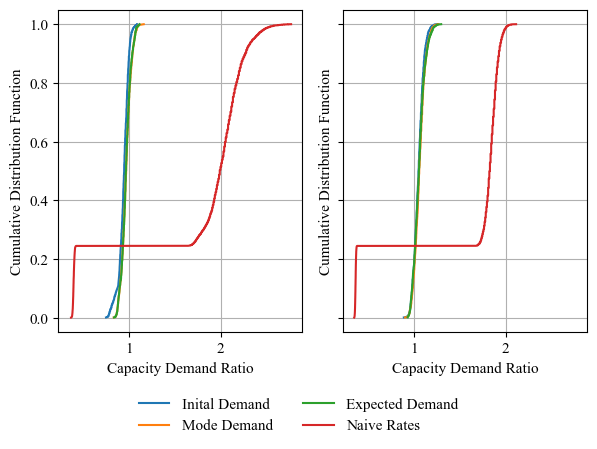

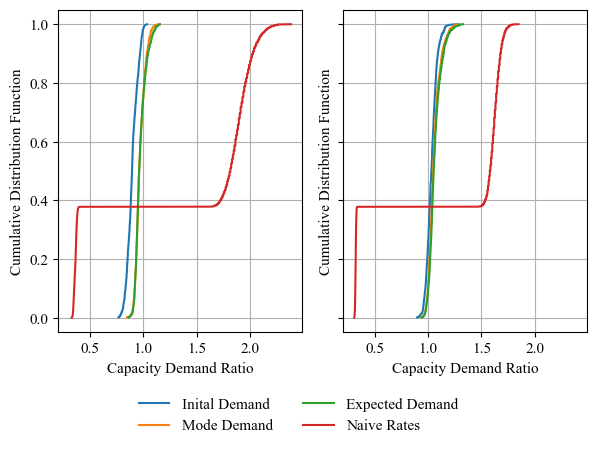

In [191]:
#  Do the same for o = 5 and rmin = 0
fig, axs = plt.subplots(1,2, figsize = (6.1, 4.2)
                            , sharex=True,
                            sharey=True)
# Do the same but for the nadir case
for idx, ax in enumerate(axs):
    ax.set_xlabel("Capacity Demand Ratio")
    ax.set_ylabel("Cumulative Distribution Function")

    if idx == 0: # Variable case nadir
        for idk in range(4):
            if idk < 3:
                CD = df_rmin_zero_o_five_variable["CD_nadir"].iloc[idk]
            else:
                CD = CD_O_equal_five_nadir[1]
            CD = np.array(CD)

            sorted_CD = np.sort(CD)
            n = len(sorted_CD)
            cdf = np.arange(1, n + 1) / n
            
            ax.plot( sorted_CD, cdf, label=labels_for_optimisatoin_plots[idk])
            
            
    if idx == 1: # Inertial case

        for idk in range(4):
            if idk < 3:
                CD = df_rmin_zero_o_five_inertial["CD_nadir"].iloc[idk]
            else:
                CD = CD_O_equal_five_nadir[0]
            CD = np.array(CD)

            sorted_CD = np.sort(CD)
            n = len(sorted_CD)
            cdf = np.arange(1, n + 1) / n
            
            ax.plot( sorted_CD, cdf)

fig.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.08),  
    ncol=2,                      
    frameon=False
)

fig.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f"CDR_histogram_nadir_o_five{rmin}.pdf", bbox_inches='tight')

# Do the same but for the case edge 

fig, axs = plt.subplots(1,2, figsize = (6.1, 4.2)
                            , sharex=True,
                            sharey=True)

for idx, ax in enumerate(axs):
    ax.set_xlabel("Capacity Demand Ratio")
    ax.set_ylabel("Cumulative Distribution Function")

    if idx == 0: # Variable case nadir
        for idk in range(4):
            if idk < 3:
                CD = df_rmin_zero_o_five_variable["CD_edge"].iloc[idk]
            else:
                CD = CD_O_equal_five_edge[1]
            CD = np.array(CD)

            sorted_CD = np.sort(CD)
            n = len(sorted_CD)
            cdf = np.arange(1, n + 1) / n
            
            ax.plot( sorted_CD, cdf, label=labels_for_optimisatoin_plots[idk])
            
            
    if idx == 1: # Inertial case

        for idk in range(4):
            if idk < 3:
                CD = df_rmin_zero_o_five_inertial["CD_edge"].iloc[idk]
            else:
                CD = CD_O_equal_five_edge[0]
            CD = np.array(CD)

            sorted_CD = np.sort(CD)
            n = len(sorted_CD)
            cdf = np.arange(1, n + 1) / n
            
            ax.plot( sorted_CD, cdf)

fig.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.08),  
    ncol=2,                      
    frameon=False
)

fig.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f"CDR_histogram_edge_o_five{rmin}.pdf", bbox_inches='tight')


In [192]:
df_rmin_zero_o_five_variable

,CD_nadir,CD_edge,CDLabel,Variability,rmin,O
5,"[0.98825294, 0.925173, 0.9154343, 0.9698839, 0...","[0.83982205, 0.82690173, 0.82690173, 0.8112998...",Initial demand,Variability,200000,5
17,"[0.925173, 0.9735029, 0.9591867, 0.95218533, 0...","[0.94444937, 0.9658331, 0.95859843, 1.0197043,...",Mode demand Variable,Variability,200000,5
29,"[0.9662918, 0.98825294, 0.92846537, 0.9698839,...","[0.9844068, 0.95502156, 0.95502156, 0.9658331,...",Expected demand Variable,Variability,200000,5


CDF at CD = 1: 0.89 for idk: 0 Variable
CDF at CD = 1: 0.74 for idk: 1 Variable
CDF at CD = 1: 0.7486666666666667 for idk: 2 Variable
CDF at CD = 1: 0.16666666666666666 for idk: 0 Inertial
CDF at CD = 1: 0.14333333333333334 for idk: 1 Inertial
CDF at CD = 1: 0.16933333333333334 for idk: 2 Inertial
CDF at CD = 1: 0.9833333333333333 for idk: 0 Variable
CDF at CD = 1: 0.7466666666666667 for idk: 1 Variable
CDF at CD = 1: 0.7446666666666667 for idk: 2 Variable
CDF at CD = 1: 0.25066666666666665 for idk: 0 Interial
CDF at CD = 1: 0.10133333333333333 for idk: 1 Interial
CDF at CD = 1: 0.08733333333333333 for idk: 2 Interial


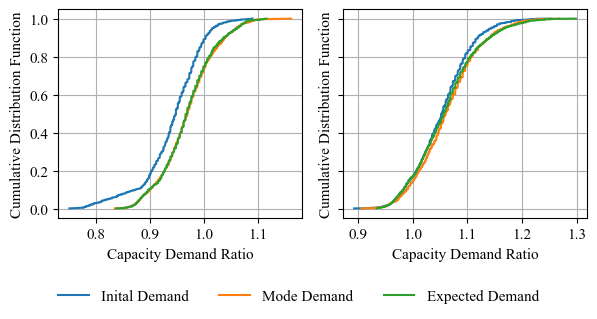

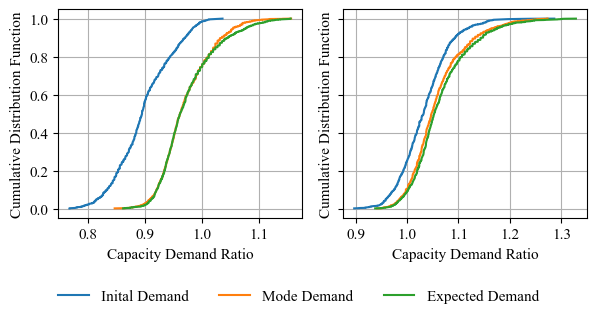

In [193]:
# Remove the naive case
fig, axs = plt.subplots(1,2, figsize = (6.1, 3)
                            , sharex=False,
                            sharey=True)
# Do the same but for the nadir case
for idx, ax in enumerate(axs):
    ax.set_xlabel("Capacity Demand Ratio")
    ax.set_ylabel("Cumulative Distribution Function")

    if idx == 0: # Variable case nadir
        for idk in range(3):
            CD = df_rmin_zero_o_five_variable["CD_nadir"].iloc[idk]
            CD = np.array(CD)

            sorted_CD = np.sort(CD)
            n = len(sorted_CD)
            cdf = np.arange(1, n + 1) / n

            cdf_at_1 = np.sum(sorted_CD <= 1) / n
            print("CDF at CD = 1:", cdf_at_1, "for idk:", idk, "Variable")

            ax.plot( sorted_CD, cdf, label=labels_for_optimisatoin_plots[idk])
            
            
    if idx == 1: # Inertial case

        for idk in range(3):
            CD = df_rmin_zero_o_five_inertial["CD_nadir"].iloc[idk]
            CD = np.array(CD)

            sorted_CD = np.sort(CD)
            n = len(sorted_CD)
            cdf = np.arange(1, n + 1) / n

            cdf_at_1 = np.sum(sorted_CD <= 1) / n
            print("CDF at CD = 1:", cdf_at_1, "for idk:", idk, "Inertial")

            ax.plot( sorted_CD, cdf)

fig.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.08),  
    ncol=4,                      
    frameon=False
)

fig.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f"CDR_cdf_nadir_o_five_no_naive{rmin}.pdf", bbox_inches='tight')
fig, axs = plt.subplots(1,2, figsize = (6.1, 3)
                            , sharex=False,
                            sharey=True)

# Do the same but for the edge case
for idx, ax in enumerate(axs):
    ax.set_xlabel("Capacity Demand Ratio")
    ax.set_ylabel("Cumulative Distribution Function")

    if idx == 0: # Variable case nadir
        for idk in range(3):
            CD = df_rmin_zero_o_five_variable["CD_edge"].iloc[idk]
            CD = np.array(CD)

            sorted_CD = np.sort(CD)
            n = len(sorted_CD)
            cdf = np.arange(1, n + 1) / n

            cdf_at_1 = np.sum(sorted_CD <= 1) / n
            print("CDF at CD = 1:", cdf_at_1, "for idk:", idk, "Variable")

            ax.plot( sorted_CD, cdf, label=labels_for_optimisatoin_plots[idk])
            
            
    if idx == 1: # Inertial case

        for idk in range(3):
            CD = df_rmin_zero_o_five_inertial["CD_edge"].iloc[idk]
            CD = np.array(CD)

            sorted_CD = np.sort(CD)
            n = len(sorted_CD)
            cdf = np.arange(1, n + 1) / n

            cdf_at_1 = np.sum(sorted_CD <= 1) / n
            print("CDF at CD = 1:", cdf_at_1, "for idk:", idk, "Interial")
            
            ax.plot( sorted_CD, cdf)
fig.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.08),  
    ncol=4,                      
    frameon=False
)
fig.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f"CDR_cdf_edge_o_five_no_naive{rmin}.pdf", bbox_inches='tight')

In [194]:
df[(df["label"] == "Mode demand Variable")]["pred demand"], df[(df["label"] == "Expected demand Variable")]["pred demand"]

(1      [28000000.0, 5600000.0, 5600000.0, 5600000.0, ...
 6      [5600000.0, 5600000.0, 5600000.0, 5600000.0, 5...
 11     [5600000.0, 5600000.0, 5600000.0, 5600000.0, 5...
 16     [5600000.0, 28000000.0, 5600000.0, 5600000.0, ...
 21     [5600000.0, 5600000.0, 5600000.0, 5600000.0, 5...
                              ...                        
 426    [28000000.0, 5600000.0, 5600000.0, 5600000.0, ...
 431    [5600000.0, 5600000.0, 5600000.0, 28000000.0, ...
 436    [5600000.0, 28000000.0, 5600000.0, 5600000.0, ...
 441    [5600000.0, 5600000.0, 28000000.0, 5600000.0, ...
 446    [5600000.0, 28000000.0, 5600000.0, 5600000.0, ...
 Name: pred demand, Length: 90, dtype: object,
 3      [28000000.0, 5600000.0, 5600000.0, 5600000.5, ...
 8      [5600001.0, 5599999.5, 5600000.0, 5600000.0, 5...
 13     [5600000.0, 5600000.0, 5600000.0, 5600000.0, 5...
 18     [5599999.5, 28000016.0, 5600001.0, 5600000.0, ...
 23     [5600000.0, 5600000.0, 5600000.0, 5600001.0, 5...
                         

0.3497495446265938


[]

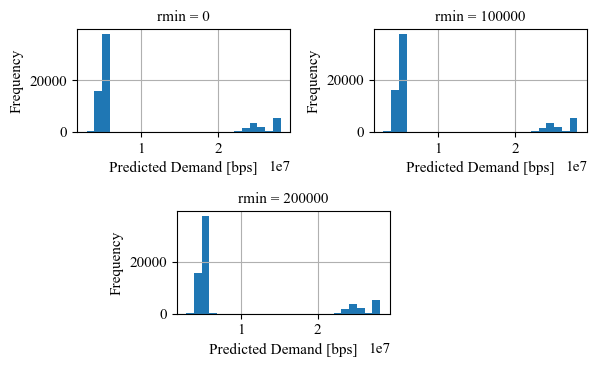

In [195]:
fig, axs = plt.subplots(2,2, figsize = (6.1, 4))
axs = axs.flatten()


for idx, ax in enumerate(axs):
    ax.set_xlabel("Predicted Demand [bps]")
    ax.set_ylabel("Frequency")
    ax.set_title(f"rmin = {idx*100000}")
    pred_demands = df[df["rmin"] == idx*100000]["pred demand"].to_list()

    ax.hist([pred_demand for pred_demand_2 in pred_demands for pred_demand in pred_demand_2], bins=25, alpha=1)

fig.delaxes(axs[3])

fig.tight_layout(rect=[0, 0.05, 1, 1])

ax_bottom = axs[2]

pos = ax_bottom.get_position()  # Bbox(x0, y0, width, height)
new_x0 = 0.3
width = pos.x1-pos.x0
print(width)
new_x1=  new_x0 + width

ax_bottom.set_position([new_x0, pos.y0, width, pos.height])
fig.savefig("pred_demand_histogram.pdf", bbox_inches='tight')

[pred_demand<200000 for pred_demand_2 in pred_demands for pred_demand in pred_demand_2]